In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pandas as pd
import numpy as np

In [ ]:
df=pd.read_csv("/content/drive/MyDrive/FYP/Stock/DataSet/Preprocessed/aapl_pca.csv")
df

,pca1,pca2,pca3,pca5,pca6,pca7,pca8,pca9,pca10,pca11,pca12,pca13,pca14,Close
0,-1.240948,0.310626,-1.082059,-0.344281,-0.120601,-0.867292,-1.113040,-0.232223,-0.765979,-0.326380,0.218670,-0.022667,-0.224595,227.134995
1,-1.276310,0.472185,-1.024411,-0.310662,-0.197822,-0.917886,-1.065268,-0.372546,-0.765072,-0.328814,0.251497,0.030292,-0.241226,227.114700
2,-1.290061,0.576287,-1.040110,-0.175207,-0.078331,-0.962452,-1.017633,-0.331210,-0.755273,-0.366515,0.289240,0.069021,-0.271961,227.130005
3,-1.221648,1.196349,-0.733527,-0.238191,-0.117287,-0.944289,-1.071218,-0.067758,-0.717330,-0.298405,0.272058,0.012933,-0.230642,227.320099
4,-1.150649,1.161411,-0.804861,-0.066815,-0.113290,-0.776544,-1.211256,0.144429,-0.707064,-0.262613,0.168363,-0.060557,-0.182320,227.389893
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2984,0.348590,-1.710591,-2.746348,0.482677,-0.118955,-0.547182,0.461750,-0.620571,-0.365824,0.248970,0.025608,0.377189,-0.041973,228.220001
2985,0.308493,-1.910803,-3.004984,0.358258,-0.081506,-0.514922,0.401825,-0.505900,-0.392472,0.278351,-0.010161,0.368929,-0.031162,228.199997
2986,0.334119,-1.162621,-2.570122,0.496028,0.013543,-0.505794,0.351383,-0.234828,-0.350352,0.289331,-0.033006,0.329121,-0.013923,228.369995
2987,0.258232,-1.905856,-2.621428,0.997974,0.422151,-0.621590,0.336270,-0.276890,-0.382468,0.210829,-0.040130,0.304080,-0.015805,228.179993


In [ ]:
def NaNCheck(data):
  return data.isnull().sum()[data.isnull().sum()>0]

In [ ]:
NaNCheck(df)

,0


## GRU Model

In [ ]:
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import math

In [ ]:
def sliding_window(x, y, window):
    x_ = []
    y_ = []
    y_gan = []
    for i in range(window, x.shape[0]):
        tmp_x = x[i - window: i, :]
        tmp_y = y[i]
        tmp_y_gan = y[i - window: i + 1]
        x_.append(tmp_x)
        y_.append(tmp_y)
        y_gan.append(tmp_y_gan)
    x_ = torch.from_numpy(np.array(x_)).float()
    y_ = torch.from_numpy(np.array(y_)).float()
    y_gan = torch.from_numpy(np.array(y_gan)).float()
    return x_, y_, y_gan

In [ ]:
sliding_window_size = 10
testing_duration = 390
training_duration = 390
sm_threshold = 50
# 6.5 hrs per day, 1d=78, 1w=78*5=390, 1m=1500
# 30d=8640, 7d=2016, 1d=288

In [ ]:
labels_df = df["Close"]
features_df = df.drop(columns=["Close"])

train_x = features_df.iloc[:training_duration]
train_y = labels_df.iloc[:training_duration]

test_x = features_df.iloc[training_duration:training_duration+testing_duration]
test_y = labels_df.iloc[training_duration:training_duration+testing_duration]

print(f'trainX: {train_x.shape} trainY: {train_y.shape}')
print(f'testX: {test_x.shape} testY: {test_y.shape}')

trainX: (390, 13) trainY: (390,)
testX: (390, 13) testY: (390,)


In [ ]:
x_scaler = MinMaxScaler(feature_range = (0, 1))
y_scaler = MinMaxScaler(feature_range = (0, 1))

train_x = x_scaler.fit_transform(train_x)
test_x = x_scaler.transform(test_x)

train_y = y_scaler.fit_transform(train_y.values.reshape(-1, 1))
test_y = y_scaler.transform(test_y.values.reshape(-1, 1))

In [ ]:
print(f'trainX: {train_x.shape} trainY: {train_y.shape}')
print(f'testX: {test_x.shape} testY: {test_y.shape}')

trainX: (390, 13) trainY: (390, 1)
testX: (390, 13) testY: (390, 1)


In [ ]:
train_x_slide, train_y_slide, train_y_gan = sliding_window(train_x, train_y, sliding_window_size)
test_x_slide, test_y_slide, test_y_gan = sliding_window(test_x, test_y, sliding_window_size)
print(f'train_x: {train_x_slide.shape} train_y: {train_y_slide.shape} train_y_gan: {train_y_gan.shape}')
print(f'test_x: {test_x_slide.shape} test_y: {test_y_slide.shape} test_y_gan: {test_y_gan.shape}')

train_x: torch.Size([380, 10, 13]) train_y: torch.Size([380, 1]) train_y_gan: torch.Size([380, 11, 1])
test_x: torch.Size([380, 10, 13]) test_y: torch.Size([380, 1]) test_y_gan: torch.Size([380, 11, 1])


In [ ]:
class Generator(nn.Module):
  def __init__(self, input_size):
    super().__init__()

    # 3 GRU layers, input_size = features
    self.gru_1 = nn.GRU(input_size, 1024, batch_first=True)
    self.gru_2 = nn.GRU(1024, 512, batch_first = True)
    self.gru_3 = nn.GRU(512, 256, batch_first = True)
    # 3 Dense Layers
    self.linear_1 = nn.Linear(256, 128)
    self.linear_2 = nn.Linear(128, 64)
    self.linear_3 = nn.Linear(64, 1)

    self.dropout = nn.Dropout(0.2)


  def forward(self, x):
    use_cuda = 1
    device = torch.device("cuda" if (torch.cuda.is_available() & use_cuda) else "cpu")
    h0 = torch.zeros(1, x.size(0), 1024).to(device) # initial hidden state for the 1st GRU Layer - (num of layers in the GRU, batch size, num of hidden units in the GRU)
    out_gru_1, _ = self.gru_1(x, h0)
    out_gru_1 = self.dropout(out_gru_1)

    h1 = torch.zeros(1, x.size(0), 512).to(device)
    out_gru_2, _ = self.gru_2(out_gru_1, h1)
    out_gru_2 = self.dropout(out_gru_2)

    h2 = torch.zeros(1, x.size(0), 256).to(device)
    out_gru_3, _ = self.gru_3(out_gru_2, h2)
    out_gru_3 = self.dropout(out_gru_3)

    out_dense_1 = self.linear_1(out_gru_3[:, -1, :])
    out_dense_2 = self.linear_2(out_dense_1)
    out_dense_3 = self.linear_3(out_dense_2)

    return out_dense_3

    # x: torch.Size([128,3,21])

    # out_gru_1:  torch.Size([128, 3, 1024])
    # out_gru_2:  torch.Size([128, 3, 512])
    # out_gru_3:  torch.Size([128, 3, 256])

    # out_dense_1:  torch.Size([128, 128])
    # out_dense_2:  torch.Size([128, 64])
    # out_dense_3:  torch.Size([128, 1])

In [ ]:
use_cuda = 1
cuda = torch.cuda.is_available()
device = torch.device("cuda" if (torch.cuda.is_available() & use_cuda) else "cpu")

batch_size = 128
learning_rate = 0.000164
num_epochs = 300

trainDataloader = DataLoader(TensorDataset(train_x_slide, train_y_slide), batch_size = batch_size, shuffle = False)
# x = [batch_size,sliding_window,features]
# y = [batch_size,sliding_window+1,1(close value)]

# Give number of features to the G
model = Generator(train_x.shape[1]).to(device)

criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)

hist = np.zeros(num_epochs)
for epoch in range(num_epochs):
    loss_ = []
    y_pred = []
    for (x, y) in trainDataloader:
        x = x.to(device)
        y = y.to(device)
        y_train_pred = model(x)
        loss = criterion(y_train_pred, y)
        loss_.append(loss.item())
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    hist[epoch] = sum(loss_)
    print('[{}/{}] Loss:'.format(epoch+1, num_epochs), sum(loss_))

[1/300] Loss: 0.5811026208102703
[2/300] Loss: 0.34922566916793585
[3/300] Loss: 0.24323762208223343
[4/300] Loss: 0.21460960432887077
[5/300] Loss: 0.1549960933625698
[6/300] Loss: 0.1478502508252859
[7/300] Loss: 0.1571637336164713
[8/300] Loss: 0.15253268741071224
[9/300] Loss: 0.1390739344060421
[10/300] Loss: 0.11987455934286118
[11/300] Loss: 0.09744028747081757
[12/300] Loss: 0.06658331025391817
[13/300] Loss: 0.05422636354342103
[14/300] Loss: 0.03937591053545475
[15/300] Loss: 0.03449935792014003
[16/300] Loss: 0.03854369651526213
[17/300] Loss: 0.02737549040466547
[18/300] Loss: 0.02160195494070649
[19/300] Loss: 0.019772824831306934
[20/300] Loss: 0.02153199235908687
[21/300] Loss: 0.020010439213365316
[22/300] Loss: 0.018837764859199524
[23/300] Loss: 0.018187149427831173
[24/300] Loss: 0.016923237359151244
[25/300] Loss: 0.019156950060278177
[26/300] Loss: 0.017146108206361532
[27/300] Loss: 0.016205020830966532
[28/300] Loss: 0.01655727718025446
[29/300] Loss: 0.016841633

Text(0.5, 0, 'Nr Epoches')

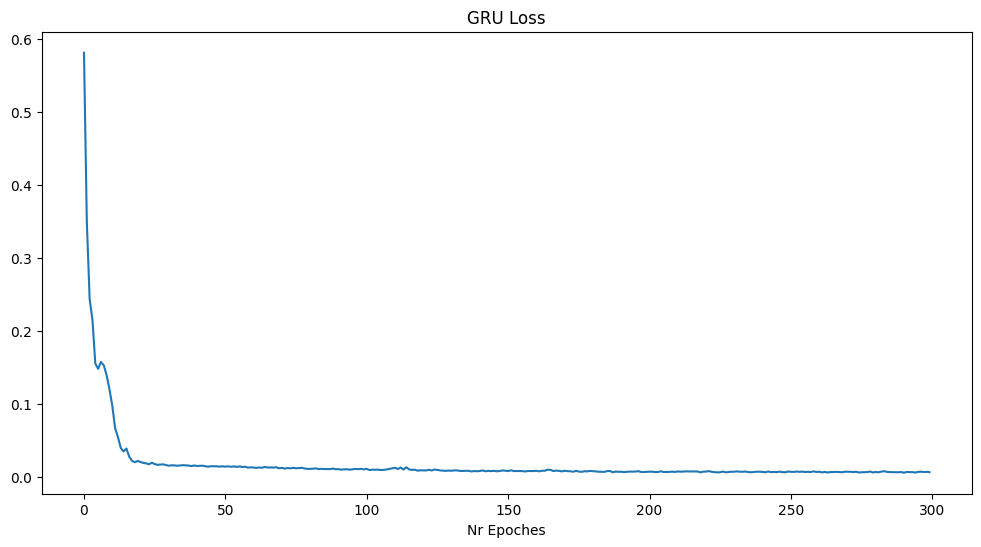

In [ ]:
plt.figure(figsize = (12, 6))
plt.plot(hist, label = 'Loss')
plt.title('GRU Loss')
plt.xlabel('Nr Epoches')

In [ ]:
model.eval()
pred_y_train = model(train_x_slide.to(device))
pred_y_test = model(test_x_slide.to(device))

y_train_true = y_scaler.inverse_transform(train_y_slide)
y_train_pred = y_scaler.inverse_transform(pred_y_train.cpu().detach().numpy())

y_test_true = y_scaler.inverse_transform(test_y_slide)
y_test_pred = y_scaler.inverse_transform(pred_y_test.cpu().detach().numpy())

Training dataset RMSE:0.3855800217795548


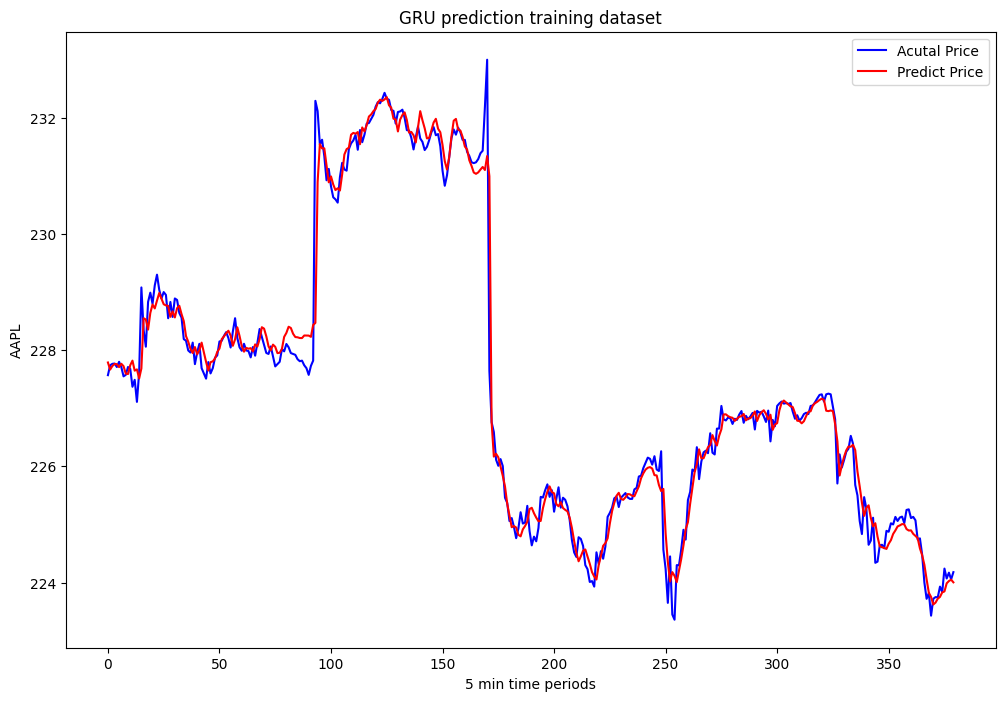

In [ ]:
plt.figure(figsize=(12, 8))
plt.plot(y_train_true, color = 'blue', label = 'Acutal Price')
plt.plot(y_train_pred, color = 'red', label = 'Predict Price')
plt.title('GRU prediction training dataset')
plt.ylabel('AAPL')
plt.xlabel('5 min time periods')
plt.legend(loc = 'upper right')

MSE = mean_squared_error(y_train_true, y_train_pred)
RMSE = math.sqrt(MSE)
print(f'Training dataset RMSE:{RMSE}')

Testing dataset RMSE:0.8613869764549266


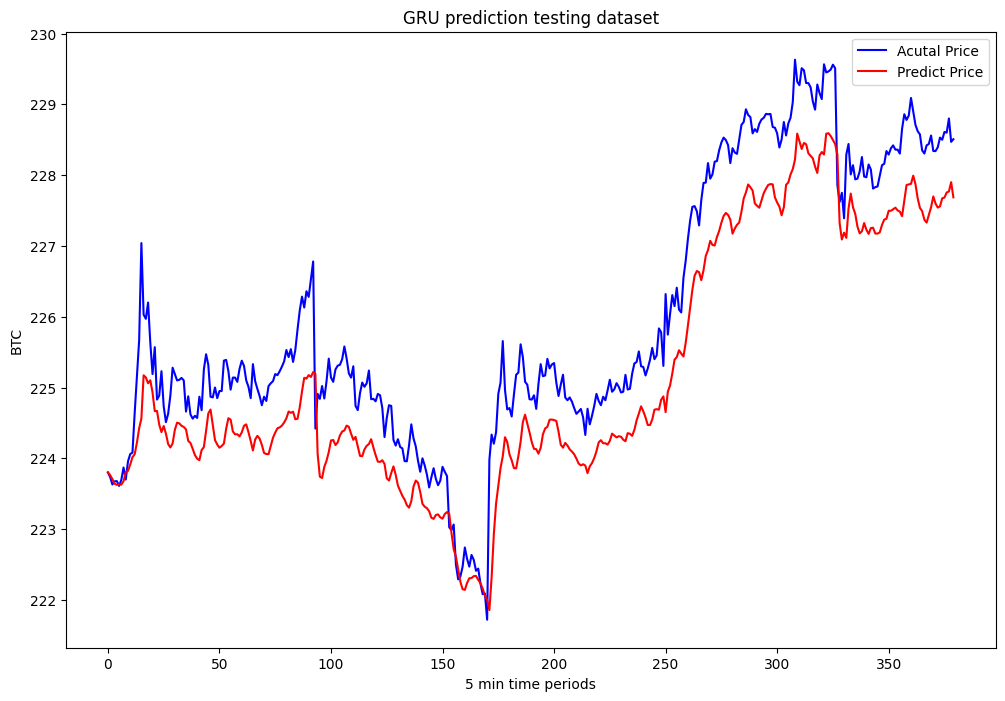

In [ ]:
plt.figure(figsize=(12, 8))
plt.plot(y_test_true, color = 'blue', label = 'Acutal Price')
plt.plot(y_test_pred, color = 'red', label = 'Predict Price')
plt.title('GRU prediction testing dataset')
plt.ylabel('BTC')
plt.xlabel('5 min time periods')
plt.legend(loc = 'upper right')

MSE = mean_squared_error(y_test_true, y_test_pred)
RMSE = math.sqrt(MSE)
print(f'Testing dataset RMSE:{RMSE}')